Saved: resultPic/exp8/exp8.pdf


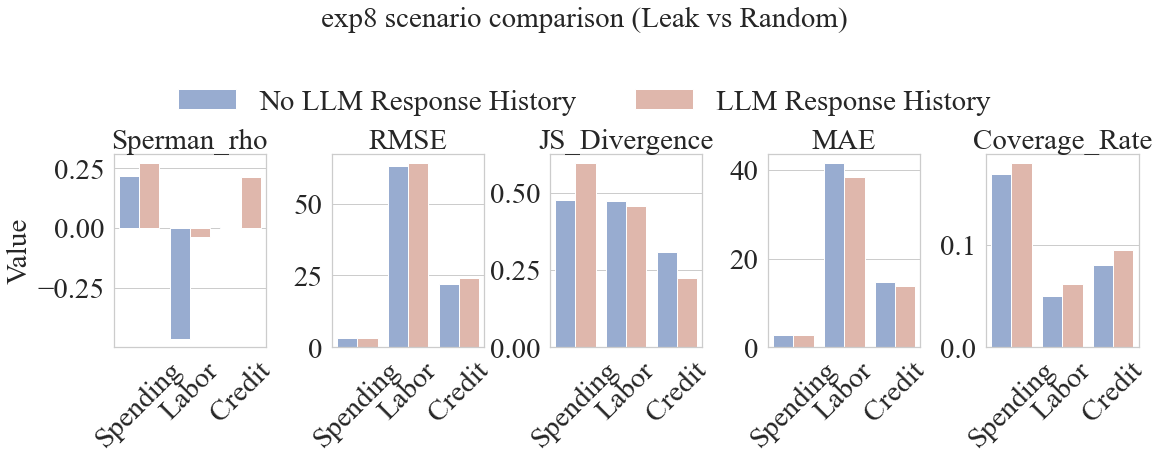

In [6]:
import json
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# 1) 读取 exp8
root = Path("exp8")
rows = []

for f in root.rglob("*.json"):
    scenario = f.parent.name  # Leak / Random
    n = f.parent.parent.name
    kind = "pointwise" if "pointwise" in f.name else "distribution"

    data = json.loads(f.read_text(encoding="utf-8"))
    for domain, metrics in data.items():
        row = {"N": n, "kind": kind, "scenario": scenario, "domain": domain}
        row.update(metrics)
        rows.append(row)

df = pd.DataFrame(rows)

# 1.5) N1 pointwise + N50 (mae, coverage_rate)
sub_n1 = df[(df["N"]=="N1") & (df["kind"]=="pointwise")].copy()
sub_n50 = df[(df["N"]=="N50") & (df["kind"]=="distribution")].copy()

sub = sub_n1.copy()
n50_metrics = [m for m in ["mae", "coverage_rate"] if m in df.columns]
if n50_metrics:
    cols = ["domain", "scenario"] + n50_metrics
    n50_vals = sub_n50[cols].dropna()
    sub = sub.drop(columns=n50_metrics, errors="ignore")
    sub = sub.merge(n50_vals, on=["domain", "scenario"], how="left")

# 3) 指标列表：pointwise + coverage_rate
metrics = ["spearman_rho", "rmse", "js_divergence", "mae", "coverage_rate"]
metrics = [m for m in metrics if m in df.columns]

domain_label_map = {"spending": "Spending", "labor": "Labor", "credit": "Credit"}
metric_label_map = {
    "spearman_rho": "Sperman_rho",
    "js_divergence": "JS_Divergence",
    "rmse": "RMSE",
    "mae": "MAE",
    "coverage_rate": "Coverage_Rate",
}
scenario_label_map = {"NoMemory": "No LLM Response History", "Memory": "LLM Response History"}
scenario_palette = {
    "No LLM Response History": "#8FAAD9",
    "LLM Response History": "#E7B2A4",
}

def format_scenario(s: str) -> str:
    return scenario_label_map.get(s, s)


def format_domain(d: str) -> str:
    return domain_label_map.get(d, d.title())

def format_metric(m: str) -> str:
    return metric_label_map.get(m, m)

# 5) 绘图
sns.set_theme(
    style="whitegrid",
    font="Times New Roman",
    rc={
        "font.size": 29,
        "axes.titlesize": 29,
        "axes.labelsize": 29,
        "xtick.labelsize": 29,
        "ytick.labelsize": 29,
        "legend.fontsize": 29,
        "figure.titlesize": 29,          
    },
)
fig, axes = plt.subplots(1, len(metrics), figsize=(3.3*len(metrics), 6.5), sharey=False)
if len(metrics) == 1:
    axes = [axes]

domain_order = [d for d in ["spending", "labor", "credit"] if d in sub["domain"].unique()]
if not domain_order:
    domain_order = sorted(sub["domain"].unique())
scenario_order = [s for s in ["NoMemory", "Memory"] if s in sub["scenario"].unique()]
if not scenario_order:
    scenario_order = sorted(sub["scenario"].unique())
scenario_display_order = [format_scenario(s) for s in scenario_order]

legend_handles = None
legend_labels = None
for ax, m in zip(axes, metrics):
    plot_sub = sub[["domain", "scenario", m]].dropna().copy()
    plot_sub["domain"] = pd.Categorical(plot_sub["domain"], categories=domain_order, ordered=True)
    plot_sub["scenario"] = pd.Categorical(plot_sub["scenario"], categories=scenario_order, ordered=True)
    plot_sub["domain_display"] = plot_sub["domain"].map(format_domain)
    plot_sub["scenario_display"] = plot_sub["scenario"].map(format_scenario)
    plot_sub["scenario_display"] = pd.Categorical(plot_sub["scenario_display"], categories=scenario_display_order, ordered=True)

    sns.barplot(
        data=plot_sub, x="domain_display", y=m, hue="scenario_display",
        ax=ax, palette=scenario_palette
    )
    if legend_handles is None:
        legend_handles, legend_labels = ax.get_legend_handles_labels()
    if ax.get_legend() is not None:
        ax.get_legend().remove()
    ax.set_title(format_metric(m))
    ax.set_xlabel("")
    ax.set_ylabel("Value" if ax == axes[0] else "")
    ax.tick_params(axis='x', rotation=45)

fig.suptitle("exp8 scenario comparison (Leak vs Random)", y=1.02)
if legend_handles is not None:
    fig.legend(legend_handles, legend_labels, loc="upper center", bbox_to_anchor=(0.5,0.9), ncol=len(legend_labels), frameon=False)
plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.subplots_adjust(wspace=0.43)

# 保存到 resultPic/exp8/exp8.pdf
out_dir = Path("resultPic") / root.name
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / f"{root.name}.pdf"
fig.savefig(out_path, dpi=300, bbox_inches="tight")
print("Saved:", out_path)

plt.show()
